## ResNet50 on NIH Maralria images

In [10]:
# Load dependencies
from py_files import config
from imutils import paths
import shutil
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np

# Load dependecies for ResNet
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from keras.datasets import mnist

Using TensorFlow backend.


#### X_train and y_train were previously generated and saved in memory to reduce training time (allows us to use fit instead of fit_generator)

In [18]:
from py_files import config
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))

In [11]:
# Initialize the training generator
# Flow_from_directory assumes a base input directory for the data split
# Also assumes that there are N subdirectories within the input directory that correspond to class labels

# Initialize the validation (and testing) data augmentation object
testAug = ImageDataGenerator(rescale=1 / 255.0)

# Initialize the testing generator
testGen = testAug.flow_from_directory(
    config.TEST_PATH,
    class_mode="categorical",
    target_size=(64,64),
    color_mode="rgb",
    shuffle=False,
    batch_size=1)

Found 5512 images belonging to 2 classes.


In [80]:
#Confirm keras is using GPU
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

#Manually set GPU config
config = tf.ConfigProto(device_count = {'GPU': 1, 'CPU': 8})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
# Load data
y_train = np.load('y_train.npy')
print('y_train loaded')
X_train = np.load('X_train.npy')
print('X_train loaded')

y_train loaded
X_train loaded


In [4]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [10]:
# Build model and compile
model = ResNet50(input_shape=(64, 64, 3), classes=2)
#opt= SGD(lr=INIT_LR, momentum=0.9) - if using scheduler
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [11]:
# Define callbacks if using a scheduler
callbacks = [LearningRateScheduler(poly_decay)]

In [14]:
H = model.fit(X_train, y_train,batch_size=128, epochs=50, validation_split=0.1)

Train on 17859 samples, validate on 1985 samples
Epoch 1/50
17859/17859 [==============================] - 135s 8ms/step - loss: 0.7442 - acc: 0.7168 - val_loss: 2.9784 - val_acc: 0.4887
Epoch 2/50
17859/17859 [==============================] - 64s 4ms/step - loss: 0.5079 - acc: 0.7687 - val_loss: 8.1968 - val_acc: 0.4887
Epoch 3/50
17859/17859 [==============================] - 65s 4ms/step - loss: 0.7343 - acc: 0.6246 - val_loss: 7.4264 - val_acc: 0.4771
Epoch 4/50
17859/17859 [==============================] - 65s 4ms/step - loss: 0.7268 - acc: 0.6560 - val_loss: 1.3426 - val_acc: 0.5567
Epoch 5/50
17859/17859 [==============================] - 65s 4ms/step - loss: 0.7573 - acc: 0.5934 - val_loss: 7.6835 - val_acc: 0.5108
Epoch 6/50
17859/17859 [==============================] - 65s 4ms/step - loss: 0.6589 - acc: 0.6496 - val_loss: 1.0674 - val_acc: 0.6141
Epoch 7/50
17859/17859 [==============================] - 65s 4ms/step - loss: 0.6224 - acc: 0.6912 - val_loss: 0.8812 - val_acc

In [29]:
# Sace model to disk
model.save("resenet50_malaria.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Create test data
# Create arrays
X_list = []
y_list = []
batch_index = 0

while batch_index <= totalTest-1:
    x,y = testGen.next()
    X_list.append(x[0])
    y_list.append(y[0])
    batch_index = batch_index + 1
    if batch_index % 1000 == 0:
        print(batch_index)
X_test = np.asarray(X_list)
y_test = np.asarray(y_list)
print('Training complete')
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [68]:
# Load test data
X_test = np.load('X_test.npy')

In [69]:
X_test.shape

(5512, 64, 64, 3)

In [70]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict(X_test)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show formatted classification report
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

[INFO] evaluating network...
              precision    recall  f1-score   support

 Parasitized       0.96      0.95      0.96      2726
  Uninfected       0.95      0.96      0.96      2786

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



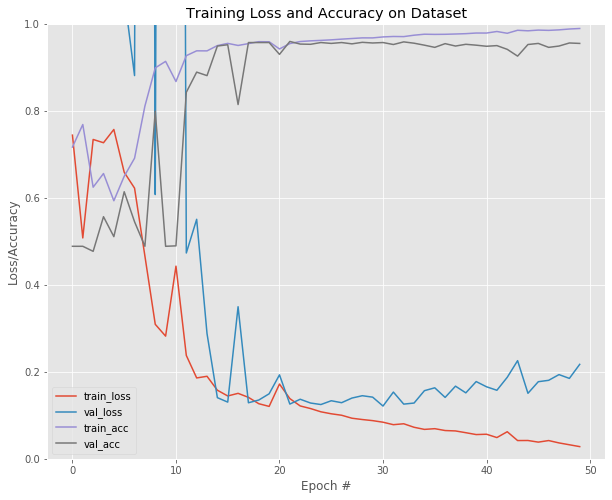

In [78]:
# plot the training loss and accuracy
N = 50
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim(0,1)
plt.legend(loc="lower left")